<center><h1>Predicting Tree Coverage in Colorado Wilderness Areas</h1><br></center>
<center><h3>Isabel Hirama</h3><br></center>

<h2>Objectives</h2><br>
The broad objective of this project is to create a neural network model using sklearn to classify types of tree
coverage - a seven-level variable - at geographical points in one of four wilderness areas in Colorado, based on natural
features at that point.<br><br>
The specific objective of the code below is to demonstrate two simple tuning methods: a for-loop that varies a single parameter, and sklearn's Grid Search, which tests combinations of levels of multiple parameters.

<h2>Data Characteristics</h2><br>
The <a href="https://www.kaggle.com/uciml/forest-cover-type-dataset">full Kaggle dataset </a> consists of 581,012 observations of thirteen natural
characteristics of thirty-by-thirty meter sections of four wilderness areas in Colorado’s Roosevelt
National Forest. Of the observations, 29,884 were in the Neota wilderness area (area 2) and were used
for training and testing the model below.<br><br>
Categorical input features with more than two levels, such
as soil type (40 levels), are represented as sets of binary variables, one for each level. This results in a total of 50 input variables used in the model.<br><br>
The features are as follows:
- <b>[Target] Cover type:</b> (7 tree types, represented by integers 1 through 7)
- <b>Elevation:</b> in meters
- <b>Aspect:</b>  in degrees azimuth
- <b>Slope:</b> in degrees
- <b>Horizontal distance to hydrology:</b> meters to nearest water feature
- <b>Vertical distance to hydrology:</b> meters to nearest water feature
- <b>Horizontal Distance to Roadways:</b> in meters
- <b>Hillshade 9am:</b> measured on the summer solstice, index from 0 to 255
- <b>Hillshade Noon:</b> measured on the summer solstice, index from 0 to 255
- <b>Hillshade 3pm:</b> measured on the summer solstice, index from 0 to 255
- <b>Horizontal Distance to Fire Points:</b> in meters, distance to wildfire ignition points
- <b>Wilderness Area:</b> 4 binary columns, for Rawah, Neota, Comanche Peak, and Cache la Poudre areas
- <b>Soil Type:</b> 40 binary columns (1 if soil type is present)


<h2>Script</h2>

<h3>Import packages and data</h3>

In [1]:
#Imports
import numpy as np
from sknn.mlp import Classifier, Layer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.grid_search import GridSearchCV
from random import sample
import pandas as pd
import matplotlib.pyplot as plt 
import time
import sys
import logging
import csv
import warnings


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 965M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5110)
C:\Users\isabe\Python-Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\isabe\Python-Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the 

In [2]:
#Hide further depreciation warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

#Set vocal settings
logging.basicConfig(
            format="%(message)s",
            level=logging.INFO,
            stream=sys.stdout)

In [3]:
################ Prepare Data ############################

#Import data for four wilderness areas
area1 = pd.read_csv("forest_area_1.csv",
                   delimiter = ',', header=0)
                   
area2 = pd.read_csv("forest_area_2.csv",
                   delimiter = ',', header=0)                   
                   
area3 = pd.read_csv("forest_area_3.csv",
                   delimiter = ',', header=0)

area4 = pd.read_csv("forest_area_4.csv",
                   delimiter = ',', header=0)

print "Area 1:", area1.shape
print "Area 2:", area2.shape
print "Area 3:", area3.shape
print "Area 4:", area4.shape
                   

Area 1: (260796, 51)
Area 2: (29884, 51)
Area 3: (253364, 51)
Area 4: (36968, 51)


In [4]:
area1.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [5]:
#Choose the dataset to be used for current iteration
data = area2                 

#Set dependent variable: Cover Type
dep_vars = ['Cover_Type']                   
dep_data = data[dep_vars]

#Set independent variables: all except Cover Type
indep_data = data
del indep_data["Cover_Type"]

<h3>For-Loop</h3>

In [6]:
################ Method 1: For-Loop ############################

#Use for varying a single parameter

#Set up parameters and result lists for for-loop testing
results =[]
times = []
levels = [1,10,50]

#For-loop testing. Set parameter being tested as T. Here, epochs (n_iter) is varied. 
for T in levels:
    print 'Starting T = ', T
    start_time = time.time()  

    #Train/Test Split                
    X_train, X_test, Y_train, Y_test = train_test_split(indep_data, dep_data, test_size=.5, random_state=2016)
    Y_train = Y_train.as_matrix()
    Y_test = Y_test.as_matrix()
    
    X_trainn = preprocessing.normalize(X_train, norm='l2')
    X_testnn = preprocessing.normalize(X_test, norm='l2')

    X_trainn = preprocessing.scale(X_trainn)
    X_testnn = preprocessing.scale(X_testnn)
    
    #Build model
    clsfr = Classifier(
    	layers=[  
           Layer("Rectifier", units=30),  
           Layer("Rectifier", units=30),
           Layer("Softmax")], 
           learning_rate=.01, 
           learning_rule='sgd',
           random_state=100,
           n_iter= T, # <---- Parameter being varied 
           #learning_momentum=T,
           #valid_size=T,
           verbose = True)
    #Fit model
    model1=clsfr.fit(X_trainn, Y_train)
    
    #Predictions
    y_hat=clsfr.predict(X_testnn)
    
    #Print scores
    print 'sgd test %s' % accuracy_score(y_hat,Y_test)
    end_time = time.time()
    times.append((end_time - start_time))
    results.append(accuracy_score(y_hat,Y_test))
    print 'time: ', (end_time - start_time)
    print


Starting T =  1
Initializing neural network with 3 layers, 50 inputs and 3 outputs.
Training on dataset of 14,942 samples with 791,926 total size.
Terminating after specified 1 total iterations..............
[(14942L, 3L)]
sgd test 0.826261544639
time:  14.7699999809

Starting T =  10
Initializing neural network with 3 layers, 50 inputs and 3 outputs.
Training on dataset of 14,942 samples with 791,926 total size.
Terminating after specified 10 total iterations........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

<function matplotlib.pyplot.show>

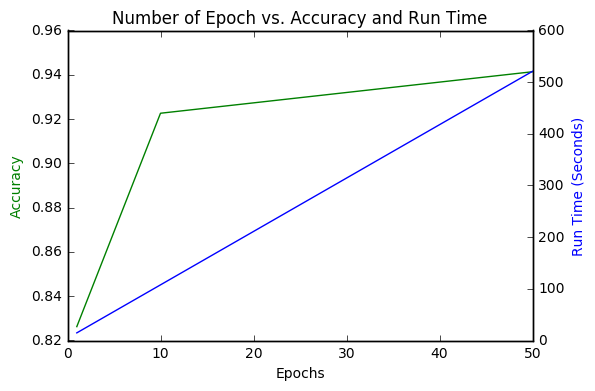

In [7]:
# Plot results (accuracy & runtime)
%matplotlib inline

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(levels, results, 'g')
ax2.plot(levels, times, 'b')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('Run Time (Seconds)', color='b')

plt.title('Number of Epoch vs. Accuracy and Run Time')

plt.show

<h3>Grid Search</h3>

<i><b>Note:</b> To save time building the notebook, in the example below only three parameters were varied, with a limited number of levels. Normally, all parameters could be varied.</i>

In [8]:

################ Method 2: Grid Search ############################

#Note: another similar option that could save time is RandomSearch

#Prepare data
Y_train = Y_train.reshape(len(Y_train),)

#Run grid search
print
print
print "Starting Grid Search"
gs = GridSearchCV(clsfr, param_grid={
    'learning_rate': [.005,.01],#[.03,.05,.075,.1]
    'hidden0__units': [10,100], #range(10,100,10),
    'hidden1__units': [10,100], #range(10,100,10),
    'hidden1__type': ["Rectifier"],#,"Tanh"],
    'hidden0__type': ["Rectifier"],#,"Tanh"]
    'n_iter': [5], #range(5,200,20)
    'valid_size':[.25]
    },
    scoring = 'accuracy', verbose = 10, cv = 2)
gs.fit(X_trainn, Y_train)




Starting Grid Search
Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] n_iter=5, hidden0__units=10, learning_rate=0.005, valid_size=0.25, hidden1__units=10, hidden1__type=Rectifier, hidden0__type=Rectifier 
Initializing neural network with 3 layers, 50 inputs and 3 outputs.
Training on dataset of 7,471 samples with 395,963 total size.
Terminating after specified 5 total iterations..............                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           
[(7471L, 3L)]
[CV]  n_iter=5, hidden0__units=10, learn

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.3s remaining:    0.0s


[CV] n_iter=5, hidden0__units=10, learning_rate=0.005, valid_size=0.25, hidden1__units=10, hidden1__type=Rectifier, hidden0__type=Rectifier 
Initializing neural network with 3 layers, 50 inputs and 3 outputs.
Training on dataset of 7,471 samples with 395,963 total size.
Terminating after specified 5 total iterations..............                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           
[(7471L, 3L)]
[CV]  n_iter=5, hidden0__units=10, learning_rate=0.005, valid_size=0.25, hidden1__units=10, hidden1__type=Rectifier, hidden

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   58.3s remaining:    0.0s


[CV] n_iter=5, hidden0__units=10, learning_rate=0.01, valid_size=0.25, hidden1__units=10, hidden1__type=Rectifier, hidden0__type=Rectifier 
Initializing neural network with 3 layers, 50 inputs and 3 outputs.
Training on dataset of 7,471 samples with 395,963 total size.
Terminating after specified 5 total iterations..............                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           
[(7471L, 3L)]
[CV]  n_iter=5, hidden0__units=10, learning_rate=0.01, valid_size=0.25, hidden1__units=10, hidden1__type=Rectifier, hidden0_

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s


[CV] n_iter=5, hidden0__units=10, learning_rate=0.01, valid_size=0.25, hidden1__units=10, hidden1__type=Rectifier, hidden0__type=Rectifier 
Initializing neural network with 3 layers, 50 inputs and 3 outputs.
Training on dataset of 7,471 samples with 395,963 total size.
Terminating after specified 5 total iterations..............                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           
[(7471L, 3L)]
[CV]  n_iter=5, hidden0__units=10, learning_rate=0.01, valid_size=0.25, hidden1__units=10, hidden1__type=Rectifier, hidden0_

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min remaining:    0.0s


[CV] n_iter=5, hidden0__units=10, learning_rate=0.005, valid_size=0.25, hidden1__units=100, hidden1__type=Rectifier, hidden0__type=Rectifier 
Initializing neural network with 3 layers, 50 inputs and 3 outputs.
Training on dataset of 7,471 samples with 395,963 total size.
Terminating after specified 5 total iterations..............                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           
[(7471L, 3L)]
[CV]  n_iter=5, hidden0__units=10, learning_rate=0.005, valid_size=0.25, hidden1__units=100, hidden1__type=Rectifier, hidd

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min remaining:    0.0s


[CV] n_iter=5, hidden0__units=10, learning_rate=0.005, valid_size=0.25, hidden1__units=100, hidden1__type=Rectifier, hidden0__type=Rectifier 
Initializing neural network with 3 layers, 50 inputs and 3 outputs.
Training on dataset of 7,471 samples with 395,963 total size.
Terminating after specified 5 total iterations..............                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           
[(7471L, 3L)]
[CV]  n_iter=5, hidden0__units=10, learning_rate=0.005, valid_size=0.25, hidden1__units=100, hidden1__type=Rectifier, hidd

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.9min remaining:    0.0s


[CV] n_iter=5, hidden0__units=10, learning_rate=0.01, valid_size=0.25, hidden1__units=100, hidden1__type=Rectifier, hidden0__type=Rectifier 
Initializing neural network with 3 layers, 50 inputs and 3 outputs.
Training on dataset of 7,471 samples with 395,963 total size.
Terminating after specified 5 total iterations..............                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           
[(7471L, 3L)]
[CV]  n_iter=5, hidden0__units=10, learning_rate=0.01, valid_size=0.25, hidden1__units=100, hidden1__type=Rectifier, hidden

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.4min remaining:    0.0s


[CV] n_iter=5, hidden0__units=10, learning_rate=0.01, valid_size=0.25, hidden1__units=100, hidden1__type=Rectifier, hidden0__type=Rectifier 
Initializing neural network with 3 layers, 50 inputs and 3 outputs.
Training on dataset of 7,471 samples with 395,963 total size.
Terminating after specified 5 total iterations..............                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           
[(7471L, 3L)]
[CV]  n_iter=5, hidden0__units=10, learning_rate=0.01, valid_size=0.25, hidden1__units=100, hidden1__type=Rectifier, hidden

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.8min remaining:    0.0s


[CV] n_iter=5, hidden0__units=100, learning_rate=0.005, valid_size=0.25, hidden1__units=10, hidden1__type=Rectifier, hidden0__type=Rectifier 
Initializing neural network with 3 layers, 50 inputs and 3 outputs.
Training on dataset of 7,471 samples with 395,963 total size.
Terminating after specified 5 total iterations..............                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           
[(7471L, 3L)]
[CV]  n_iter=5, hidden0__units=100, learning_rate=0.005, valid_size=0.25, hidden1__units=10, hidden1__type=Rectifier, hidd

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.3min remaining:    0.0s


[CV] n_iter=5, hidden0__units=100, learning_rate=0.005, valid_size=0.25, hidden1__units=10, hidden1__type=Rectifier, hidden0__type=Rectifier 
Initializing neural network with 3 layers, 50 inputs and 3 outputs.
Training on dataset of 7,471 samples with 395,963 total size.
Terminating after specified 5 total iterations..............                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           
[(7471L, 3L)]
[CV]  n_iter=5, hidden0__units=100, learning_rate=0.005, valid_size=0.25, hidden1__units=10, hidden1__type=Rectifier, hidd

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  7.6min finished


Initializing neural network with 3 layers, 50 inputs and 3 outputs.
Training on dataset of 14,942 samples with 791,926 total size.
Terminating after specified 5 total iterations..............                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           ...........................................................                                                           


GridSearchCV(cv=2, error_score='raise',
       estimator=Classifier(batch_size=1, callback=None, debug=False, dropout_rate=None,
      f_stable=0.001,
      hidden0=<sknn.nn.Layer `Rectifier`: units=30, name=u'hidden0', frozen=False>,
      hidden1=<sknn.nn.Layer `Rectifier`: units=30, name=u'hidden1', frozen=False>,
      layers=[<sknn.nn.Layer...egularize=None, valid_set=None,
      valid_size=0.0, verbose=True, warning=None, weight_decay=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_iter': [5], 'hidden0__units': [10, 100], 'learning_rate': [0.005, 0.01], 'valid_size': [0.25], 'hidden1__units': [10, 100], 'hidden1__type': ['Rectifier'], 'hidden0__type': ['Rectifier']},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=10)

In [9]:

#Display best parameters and result
print("Best: %f using %s" % (gs.best_score_, gs.best_params_))


Best: 0.890175 using {'n_iter': 5, 'hidden0__units': 100, 'learning_rate': 0.01, 'valid_size': 0.25, 'hidden1__units': 100, 'hidden1__type': 'Rectifier', 'hidden0__type': 'Rectifier'}


In [10]:
##### Output Grid Search results to a csv

#Prepare array
arrayofdata = []
labels = gs.grid_scores_[0][0].keys()
labels.append('mean')
arrayofdata.append(labels)

#Add results to array
for line in gs.grid_scores_:
    rowdata = []
    for key in gs.grid_scores_[0][0].keys():
        rowdata.append(line[0][key])
    rowdata.append(line[1])
    arrayofdata.append(rowdata)

#Write to csv
with open('gridsearch_results.csv', 'wb') as mycsvfile:
    thedatawriter = csv.writer(mycsvfile)
    for row in arrayofdata:
        thedatawriter.writerow(row)    
        
print "Done writing results to CSV file."

Done writing results to CSV file.


<h2>Conclusion</h2><br>

Unsurprisingly, results from the for-loop indicate that as n_iter (epochs) increases, both accuracy and run time increase. Testing should be extended to higher levels of n_iter to identify the point of where the diminishing returns in accuracy are no longer worth the added run time.

Among grid search results, the highest accuracy was achieved with the following parameter levels:<br><br>
<b>Learning Rate: </b>.01<br>
<b>Nodes in Layer 1: </b>100<br>
<b>Nodes in Layer 2: </b>100<br>
<br>
Extending the experiment, more parameters should be varied across more levels.